<a href="https://colab.research.google.com/github/KasunJayasanka/ML-Lab/blob/main/ML_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fastf1


In [ ]:
import os
os.makedirs('/content/f1cache', exist_ok=True)

import fastf1
from fastf1 import plotting

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

fastf1.Cache.enable_cache('/content/f1cache')

print("FastF1 version:", fastf1.__version__)


FastF1 version: 3.7.0


In [ ]:
session = fastf1.get_session(2023, 'Bahrain', 'R')
session.load()

print("Session loaded:", session.event.name, session.name)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

Session loaded: 1 Race


In [ ]:
# Select driver
driver = "VER"

# Get laps
laps = session.laps.pick_drivers(driver)

rows = []

for _, lap in laps.iterrows():
    try:
        tel = lap.get_car_data().add_distance()   # telemetry for this lap

        rows.append({
            "mean_speed": tel["Speed"].mean(),
            "mean_throttle": tel["Throttle"].mean(),
            "mean_brake": tel["Brake"].mean(),
            "mean_gear": tel["nGear"].mean(),
            "lap_time": lap["LapTime"].total_seconds()
        })
    except:
        # some laps have no telemetry (e.g., formation lap)
        continue

df = pd.DataFrame(rows)

# Remove NaN rows
df = df.dropna()

# Create label: fast vs slow
median_time = df["lap_time"].median()
df["label"] = (df["lap_time"] < median_time).astype(int)

df.head()


,mean_speed,mean_throttle,mean_brake,mean_gear,lap_time,label
0,185.071053,59.876316,0.202632,4.602632,99.019,0
1,195.407713,60.225895,0.203857,5.115702,97.974,0
2,198.095109,62.290761,0.184783,5.179348,98.006,0
3,195.786842,62.092105,0.200000,5.139474,97.976,0
4,197.120879,60.884615,0.206044,5.211538,98.035,0


In [ ]:
df.shape

(57, 6)

In [ ]:
# Features and labels
X = df[["mean_speed", "mean_throttle", "mean_brake", "mean_gear"]]
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_model.fit(X_train_scaled, y_train)


SVC()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.55      1.00      0.71         6

    accuracy                           0.67        15
   macro avg       0.77      0.72      0.66        15
weighted avg       0.82      0.67      0.65        15



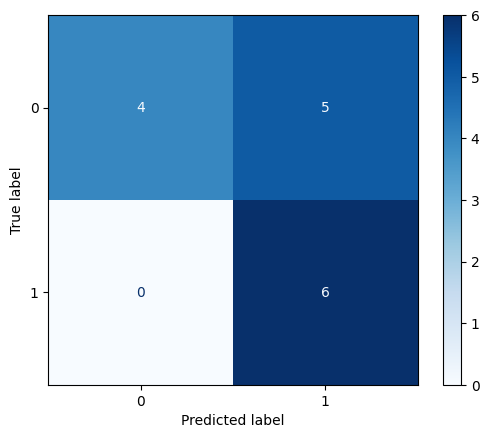

In [ ]:
y_pred = svm_model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.show()


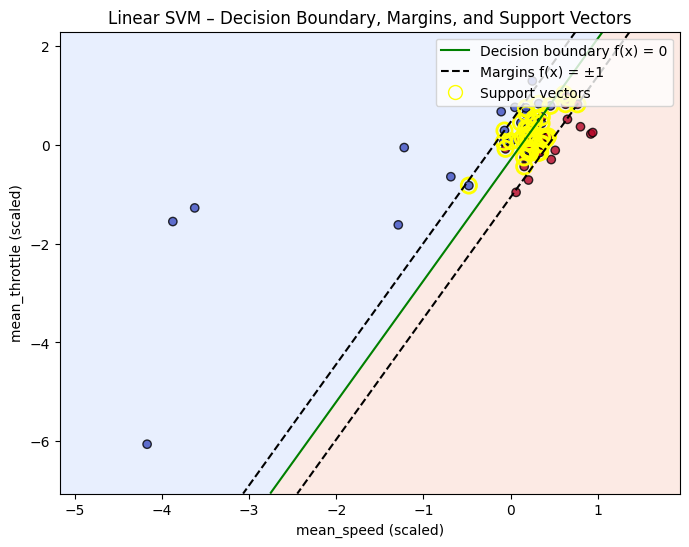

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 1️⃣ Data: two features + labels
X_vis = df[["mean_speed", "mean_throttle"]].values
y_vis = df["label"].values

# 2️⃣ Scale
scaler_lin = StandardScaler()
X_vis_scaled = scaler_lin.fit_transform(X_vis)

# 3️⃣ Linear SVM (for clean margins)
svm_lin = SVC(kernel="linear", C=1.0)
svm_lin.fit(X_vis_scaled, y_vis)

# 4️⃣ Make grid
xx, yy = np.meshgrid(
    np.linspace(X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1, 500),
    np.linspace(X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1, 500)
)

grid = np.c_[xx.ravel(), yy.ravel()]

# Decision function = signed distance (up to scaling)
Z = svm_lin.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))

# Background regions (fast/slow)
plt.contourf(xx, yy, Z > 0, alpha=0.2, cmap="coolwarm")

# Decision boundary and margins
plt.contour(
    xx, yy, Z,
    levels=[-1, 0, 1],
    colors=["black", "green", "black"],
    linestyles=["dashed", "solid", "dashed"]
)

# Points
plt.scatter(
    X_vis_scaled[:, 0],
    X_vis_scaled[:, 1],
    c=y_vis,
    cmap="coolwarm",
    edgecolors="k",
    alpha=0.8
)

# Support vectors
plt.scatter(
    svm_lin.support_vectors_[:, 0],
    svm_lin.support_vectors_[:, 1],
    s=120,
    facecolors="none",
    edgecolors="yellow",
    linewidths=2
)

# Legend using proxy artists
legend_elements = [
    Line2D([0], [0], color="green", linestyle="solid", label="Decision boundary f(x) = 0"),
    Line2D([0], [0], color="black", linestyle="dashed", label="Margins f(x) = ±1"),
    Line2D([0], [0], marker="o", linestyle="None",
           markerfacecolor="none", markeredgecolor="yellow",
           markersize=10, label="Support vectors")
]

plt.xlabel("mean_speed (scaled)")
plt.ylabel("mean_throttle (scaled)")
plt.title("Linear SVM – Decision Boundary, Margins, and Support Vectors")
plt.legend(handles=legend_elements, loc="upper right")
plt.show()


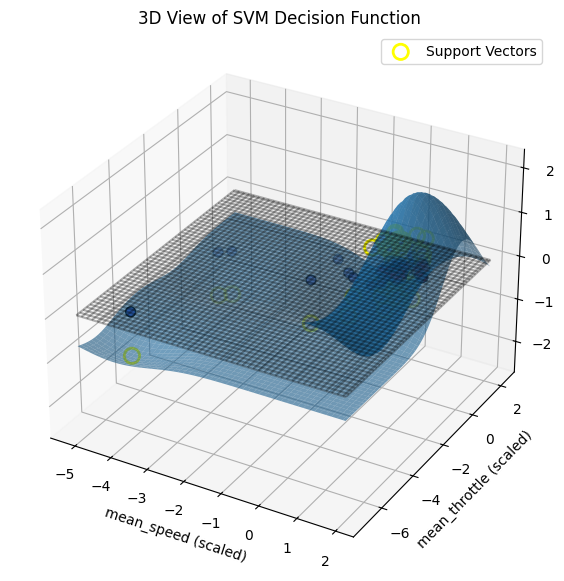

In [32]:
from mpl_toolkits.mplot3d import Axes3D  # just to register 3D projection

# If not available in this scope, rebuild minimal pieces:
# X_vis = df[["mean_speed", "mean_throttle"]].values
# y_vis = df["label"].values
# scaler_3d = StandardScaler()
# X_vis_scaled = scaler_3d.fit_transform(X_vis)
# svm_vis = SVC(kernel="rbf", C=1.0, gamma="scale")
# svm_vis.fit(X_vis_scaled, y_vis)

# Grid in 2D feature space
xx, yy = np.meshgrid(
    np.linspace(X_vis_scaled[:, 0].min() - 1, X_vis_scaled[:, 0].max() + 1, 100),
    np.linspace(X_vis_scaled[:, 1].min() - 1, X_vis_scaled[:, 1].max() + 1, 100)
)

grid = np.c_[xx.ravel(), yy.ravel()]

# Decision function: positive = one class, negative = other
Z = svm_vis.decision_function(grid)
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# 3D surface of decision function
surf = ax.plot_surface(xx, yy, Z, alpha=0.6)

# Plot training points at z=0
ax.scatter(
    X_vis_scaled[:, 0],
    X_vis_scaled[:, 1],
    np.zeros_like(y_vis),
    c=y_vis,
    cmap="coolwarm",
    edgecolors="k",
    s=50
)

# Plot support vectors with their decision value
sv = svm_vis.support_vectors_
sv_z = svm_vis.decision_function(sv)

ax.scatter(
    sv[:, 0],
    sv[:, 1],
    sv_z,
    s=120,
    facecolors="none",
    edgecolors="yellow",
    linewidths=2,
    label="Support Vectors"
)

# Zero plane (decision boundary)
z0 = np.zeros_like(xx)
ax.plot_wireframe(xx, yy, z0, color="black", alpha=0.3)

ax.set_xlabel("mean_speed (scaled)")
ax.set_ylabel("mean_throttle (scaled)")
ax.set_zlabel("decision_function(x)")
ax.set_title("3D View of SVM Decision Function")
plt.legend()
plt.show()
